In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score

from catboost import CatBoost
from catboost import CatBoostRegressor
from catboost import Pool
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ykc-2nd/test.csv
/kaggle/input/ykc-2nd/sample_submission.csv
/kaggle/input/ykc-2nd/train.csv
/kaggle/input/ykc-2nd/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec
/kaggle/input/ykc2nn/nn_oof.csv
/kaggle/input/ykc2nn/checkpoint_fold_5.pt
/kaggle/input/ykc2nn/checkpoint_fold_1.pt
/kaggle/input/ykc2nn/checkpoint_fold_3.pt
/kaggle/input/ykc2nn/nn_test.csv
/kaggle/input/ykc2nn/checkpoint_fold_4.pt
/kaggle/input/ykc2nn/submission.csv
/kaggle/input/ykc2nn/checkpoint_fold_2.pt
/kaggle/input/yjfasttext/fasttext_gensim_model.pkl


In [2]:
# 今あるモデル
    # lightgbm, catboost, lstm


# NLP系の特徴の追加
    # product_nameをスペースで区切る
    # 区切った単語をラベルエンコーディングで数値に変換
    # 区切った単語を分散表現に変換（次元数はvalidationのスコアを見ながら調整する）
    # ノルムを加える
    # ストップワード

    
# モデルのアンサンブル
    # 現状voting
    # 重みづけ
    # 0.6*catboost + 0.2*lightgbm + 0.2*lstm

In [3]:
train = pd.read_csv('/kaggle/input/ykc-2nd/train.csv')
test = pd.read_csv('/kaggle/input/ykc-2nd/test.csv')
sample_sub = pd.read_csv('/kaggle/input/ykc-2nd/sample_submission.csv')
nn_oof = pd.read_csv("/kaggle/input/ykc2nn/nn_oof.csv")
nn_test = pd.read_csv("/kaggle/input/ykc2nn/nn_test.csv")

print(f'train: {train.shape}')
print(f'test: {test.shape}')
print(f'sample_sub: {sample_sub.shape}')

train: (24842, 6)
test: (24843, 5)
sample_sub: (24843, 2)


In [4]:
train.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
0,0,All-Seasons Salt,2.779494e-06,0,11,12
1,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,1.037875e-05,0,16,0
2,2,Green Chile Anytime Sauce,4.731054e-07,0,11,12
3,3,Dry Nose Oil,2.365527e-07,6,10,10
4,4,Pure Coconut Water With Orange,9.166416e-07,3,14,6


In [5]:
# import re

# # https://024minion.hatenablog.jp/entry/2017/05/07/210020

# def ngram(splited, scale):
#     str = ''
#     wordlist = []

#     if scale > len(splited):
#         print("ERROR: The argument, scale must be lawer than the actual number of the words in the argument, sentense.")
#     else:
#         for i in range (0, len(splited)-(scale-1)):
#             for ii in range (0, scale):
#                 if ii == 0:
#                     str += splited[ii+i]
#                 else:
#                     str += ' ' + splited[ii+i]
#             wordlist.insert(i, str)
#             str = ''

#         return wordlist
# aaa = train.product_name.iloc[1]
# data1 = ngram(aaa, 3)

In [6]:
# def group_feature_engineering(df, group_key, aggs):
#     group_df = df.groupby(group_key).agg(aggs)
#     group_df.columns = ["{}_{}".format(key, val) for key in aggs for val in aggs[key]]
#     group_df.reset_index(inplace=True)
#     return group_df

In [7]:
# group_key = ['product_id', 'product_name', 'department_id']

# aggs = {
#     'is_order': ['sum', 'count']
# }

# group = group_feature_engineering(origin,group_key, aggs)

## FE

In [8]:
model = pd.read_pickle("/kaggle/input/yjfasttext/fasttext_gensim_model.pkl") 

def fe_label_encode(train, test, category_feats):
    for c in category_feats:
        le = LabelEncoder()
        train[c] = le.fit_transform(train[c].fillna("na"))
        test[c] = le.transform(test[c].fillna("na"))
    print('fe_label_encode done train: ', train.shape)
    print('fe_label_encode done test: ', test.shape)

def fe_get_word_begin(row):
    words = row['product_name']
    num = row['product_name_len_split_3']
    return words[:num]

def fe_get_word_middle(row):
    words = row['product_name']
    num = row['product_name_len_split_3']
    return words[num:num*2]

def fe_get_word_end(row):
    words = row['product_name']
    num = row['product_name_len_split_3']
    return words[num*2:]

def to_vec(x, model):
    unused_words = defaultdict(int)
#     v = np.zeros(model.vector_size)
    v = np.zeros(300)
    for idx, w in enumerate(x):
#         if w in stop_words:
#             continue
        try:
            v += model[w][:300] ## 単語が訓練済みモデルのvocabにあったら
        except:
            unused_words[w] += 1 ## ベクトルが存在しなかった単語をメモ
    v = v / (np.sqrt(np.sum(v ** 2)) + 1e-16) ## 長さを1に正規化
    return v 

def fe_vec(data, target_col):
    vecs = data[target_col].apply(lambda x : to_vec(x, model))
    vecs = np.vstack(vecs)

    fasttext_pretrain_cols = [f"fasttext_{target_col}_{k}" for k in range(vecs.shape[1])]
    vec_df = pd.DataFrame(vecs, columns=fasttext_pretrain_cols)
    data = pd.concat([data, vec_df], axis = 1)
    return data
    
    
def fe_pipeline(train, test):
    train['is_test'] = 0
    test['is_test'] = 1

    data = pd.concat([train, test], sort=False)
    data.reset_index(drop=True, inplace=True)

    data["product_name"] = data["product_name"].apply(lambda words : words.lower().replace(",", "").replace("&", "").split(" "))
    data['product_name_len'] = data["product_name"].map(len)
    # train['sub_category_1'] = train['product_name'].apply(lambda x: x[0])

    data['product_name_len_split_3'] = data['product_name_len'].map(lambda x: int(x/3))
    data['begin'] = data[['product_name', 'product_name_len_split_3']].apply(fe_get_word_begin, axis=1)
    data['middle'] = data[['product_name', 'product_name_len_split_3']].apply(fe_get_word_middle, axis=1)
    data['end'] = data[['product_name', 'product_name_len_split_3']].apply(fe_get_word_end, axis=1)
    
    data = fe_vec(data, 'product_name')
    data = fe_vec(data, 'begin')
    data = fe_vec(data, 'middle')
    data = fe_vec(data, 'end')

    train = data[data['is_test']==0].reset_index(drop=True)
    test = data[data['is_test']==1].reset_index(drop=True)
    train = train.join(nn_oof)
    test = test.join(nn_test)
    
    del train['is_test']
    del test['is_test']
    
    print('fe_pipeline done, train: {}, test: {}'.format(train.shape, test.shape))
    return train, test

In [9]:
train.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id
0,0,All-Seasons Salt,2.779494e-06,0,11,12
1,1,Smart Ones Classic Favorites Mini Rigatoni Wit...,1.037875e-05,0,16,0
2,2,Green Chile Anytime Sauce,4.731054e-07,0,11,12
3,3,Dry Nose Oil,2.365527e-07,6,10,10
4,4,Pure Coconut Water With Orange,9.166416e-07,3,14,6


In [10]:
train, test = fe_pipeline(train, test)


# category_feats = []
# fe_label_encode(train, test, category_feats)

train.head()

fe_pipeline done, train: (24842, 1232), test: (24843, 1232)


,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id,product_name_len,product_name_len_split_3,begin,middle,...,11,12,13,14,15,16,17,18,19,20
0,0,"[all-seasons, salt]",2.779494e-06,0,11,12.0,2,0,[],[],...,-8.762543,0.635433,-4.931417,-8.044229,-6.152822,-5.257716,-10.079609,-1.831705,-10.229215,-3.978502
1,1,"[smart, ones, classic, favorites, mini, rigato...",1.037875e-05,0,16,0.0,10,3,"[smart, ones, classic]","[favorites, mini, rigatoni]",...,-8.872455,-12.293959,-7.874230,-6.116001,-7.506086,-8.261728,-3.693510,-7.945728,-6.447669,-3.407856
2,2,"[green, chile, anytime, sauce]",4.731054e-07,0,11,12.0,4,1,[green],[chile],...,-11.633402,3.476219,-13.584162,-7.549783,-7.302247,-11.802956,-16.465631,-9.306204,-5.498493,-6.351920
3,3,"[dry, nose, oil]",2.365527e-07,6,10,10.0,3,1,[dry],[nose],...,-9.801481,-7.647671,-13.374285,-15.067058,-10.814124,-0.139730,-9.718052,-12.265686,-13.746184,-5.329216
4,4,"[pure, coconut, water, with, orange]",9.166416e-07,3,14,6.0,5,1,[pure],[coconut],...,-18.732269,-7.473756,-17.692984,-7.551906,-9.566477,-11.835156,-15.422378,-7.013528,-9.374475,-4.871702


In [11]:
def after_preparation_importance(feats, model, n_fold):
    imp_df = pd.DataFrame()
    imp_df["feature"] = feats
    imp_df["importance"] = model.feature_importance(importance_type='gain', iteration=model.best_iteration)
    imp_df["fold"] = n_fold + 1
    return imp_df

def after_display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]]\
        .groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.show()

In [12]:
def model_get_feats(train, excluded_feats):
    features = [col for col in train.columns if col not in excluded_feats]
    print(f'features len: {len(features)}')
    return features

def model_get_fold(train, n_split=5, fold_type=None, seed=24):
    fold_type = validation_params['fold_type']
    n_split = validation_params['n_split']
    seed = validation_params['seed']
    
    if fold_type == 'kfold':
        kfold = KFold(n_splits=n_split, shuffle = True, random_state=seed)
        fold = kfold.split(train)
    elif fold_type == 'stratified':
        skfold = StratifiedKFold(n_splits=n_split, shuffle = True, random_state=seed)
        fold = skfold.split(train, train[validation_params['stratified_col']])
    else:
        print('invalid fold_type: ', fold_type)
    return fold

In [13]:
def model_rmse(preds, true):
    return mean_squared_error(preds, true)**0.5

def model_micro_f1_score(preds, true):
    return f1_score(true, np.argmax(preds, axis = 1), average = "micro")

def model_run_lgb(train, test, lgb_params, features, target_col, validation_params, metric_func):
    fold = model_get_fold(train, validation_params)

    preds_cv = []
    preds_test = []
    feature_importance_df = pd.DataFrame()
    oof_preds = np.zeros((train.shape[0], train[target_col].nunique()))

    for idx, (train_idx, valid_idx) in enumerate(fold):
        print("--------fold {} -------".format(idx+1))

        ## train data
        x_train = train.loc[train_idx, features]
        y_train = train.loc[train_idx, target_col]

        ## valid data
        x_valid = train.loc[valid_idx, features]
        y_valid = train.loc[valid_idx, target_col]

        lgb_train = lgb.Dataset(x_train.values, label=y_train)
        lgb_valid = lgb.Dataset(x_valid.values, label=y_valid)

        model = lgb.train(
            lgb_params,
            lgb_train,
            valid_sets=[lgb_train, lgb_valid],
            valid_names=['train', 'valid'],
            num_boost_round=3000,
            early_stopping_rounds=100,
            verbose_eval=100
        )

        # valid
        valid_preds = model.predict(x_valid.values)
        valid_metric = metric_func(valid_preds, y_valid)
        preds_cv.append(valid_metric)
        
        train.loc[valid_idx, 'lgb_pred'] = np.argmax(valid_preds, axis = 1)
        oof_preds[valid_idx, :] = valid_preds

        # test
        pred_test = model.predict(test[features].values)
        preds_test.append(pred_test)

        # importance
        fold_importance_df = after_preparation_importance(features, model, validation_params["n_split"])
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print('Valid Metric: {:.5f}'.format(valid_metric))

    print('Valid OverAll: {:.5f}'.format(np.mean(preds_cv)))
    return feature_importance_df, preds_test, preds_cv, oof_preds

In [14]:
train.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id,product_name_len,product_name_len_split_3,begin,middle,...,11,12,13,14,15,16,17,18,19,20
0,0,"[all-seasons, salt]",2.779494e-06,0,11,12.0,2,0,[],[],...,-8.762543,0.635433,-4.931417,-8.044229,-6.152822,-5.257716,-10.079609,-1.831705,-10.229215,-3.978502
1,1,"[smart, ones, classic, favorites, mini, rigato...",1.037875e-05,0,16,0.0,10,3,"[smart, ones, classic]","[favorites, mini, rigatoni]",...,-8.872455,-12.293959,-7.874230,-6.116001,-7.506086,-8.261728,-3.693510,-7.945728,-6.447669,-3.407856
2,2,"[green, chile, anytime, sauce]",4.731054e-07,0,11,12.0,4,1,[green],[chile],...,-11.633402,3.476219,-13.584162,-7.549783,-7.302247,-11.802956,-16.465631,-9.306204,-5.498493,-6.351920
3,3,"[dry, nose, oil]",2.365527e-07,6,10,10.0,3,1,[dry],[nose],...,-9.801481,-7.647671,-13.374285,-15.067058,-10.814124,-0.139730,-9.718052,-12.265686,-13.746184,-5.329216
4,4,"[pure, coconut, water, with, orange]",9.166416e-07,3,14,6.0,5,1,[pure],[coconut],...,-18.732269,-7.473756,-17.692984,-7.551906,-9.566477,-11.835156,-15.422378,-7.013528,-9.374475,-4.871702


In [15]:
lgb_params = {
    'boost': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 21,
    'learning_rate': 0.05, 
    "max_depth": 14, # default: -1
    "lambda_l1": 0.01, # default: 0
    "lambda_l2": 0.01, # default: 0
#     "bagging_fraction": 0.7,
#     "bagging_freq": 5,
#     "feature_fraction": 0.8, 
    'verbosity': 1,
}

validation_params = {
    'seed': 24,
    'n_split': 3,
#     'fold_type': 'kfold',
    'fold_type': 'stratified',
    'stratified_col': 'department_id'
}

metric_func = model_micro_f1_score


excluded_feats = ['lgb_pred', 'catboost_pred', 'product_id', 'department_id', 'product_name', 'product_name_len_split_3', 'begin', 'middle', 'end']
lgb_features = model_get_feats(train, excluded_feats)

feature_importance_df, preds_test, preds_cv, oof_preds = model_run_lgb(train, test, lgb_params, lgb_features, 'department_id', validation_params, metric_func)

features len: 1225
--------fold 1 -------
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.194222	valid's multi_logloss: 0.98375
[200]	train's multi_logloss: 0.0464685	valid's multi_logloss: 1.05305
Early stopping, best iteration is:
[109]	train's multi_logloss: 0.168472	valid's multi_logloss: 0.98253
Valid Metric: 0.73494
--------fold 2 -------
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.196113	valid's multi_logloss: 0.95813
[200]	train's multi_logloss: 0.0468	valid's multi_logloss: 0.994351
Early stopping, best iteration is:
[122]	train's multi_logloss: 0.139714	valid's multi_logloss: 0.952671
Valid Metric: 0.73856
--------fold 3 -------
Training until validation scores don't improve for 100 rounds
[100]	train's multi_logloss: 0.199438	valid's multi_logloss: 0.929514
[200]	train's multi_logloss: 0.0483251	valid's multi_logloss: 0.951945
Early stopping, best iteration is:
[126]	train's multi_l

In [16]:
# features len: 404
# --------fold 1 -------
# Training until validation scores don't improve for 100 rounds
# [100]	train's multi_logloss: 0.436263	valid's multi_logloss: 1.21576
# [200]	train's multi_logloss: 0.139931	valid's multi_logloss: 1.08696
# [300]	train's multi_logloss: 0.0511771	valid's multi_logloss: 1.07797
# Early stopping, best iteration is:
# [263]	train's multi_logloss: 0.0733858	valid's multi_logloss: 1.07419
# Valid Metric: 0.71368
# --------fold 2 -------
# Training until validation scores don't improve for 100 rounds
# [100]	train's multi_logloss: 0.438485	valid's multi_logloss: 1.21305
# [200]	train's multi_logloss: 0.141454	valid's multi_logloss: 1.07321
# [300]	train's multi_logloss: 0.0522864	valid's multi_logloss: 1.05767
# Early stopping, best iteration is:
# [291]	train's multi_logloss: 0.0569629	valid's multi_logloss: 1.05718
# Valid Metric: 0.71296
# --------fold 3 -------
# Training until validation scores don't improve for 100 rounds
# [100]	train's multi_logloss: 0.444835	valid's multi_logloss: 1.17839
# [200]	train's multi_logloss: 0.145384	valid's multi_logloss: 1.03792
# [300]	train's multi_logloss: 0.0542027	valid's multi_logloss: 1.02004
# Early stopping, best iteration is:
# [287]	train's multi_logloss: 0.06131	valid's multi_logloss: 1.0191
# Valid Metric: 0.72717
# Valid OverAll: 0.71794

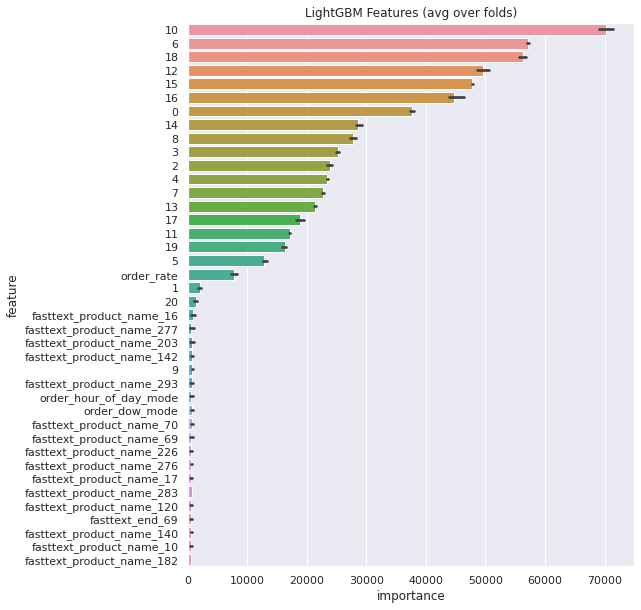

In [17]:
after_display_importances(feature_importance_df)

In [18]:
# def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.tight_layout()


# def calc_confusion(y, oof_preds, class_names, is_binary):

#     unique_y = np.unique(y)
#     class_map = dict()
#     for i,val in enumerate(unique_y):
#         class_map[val] = i

#     y_map = np.array([class_map[val] for val in y])
    
#     if is_binary:
#         cnf_matrix = confusion_matrix(y_map, oof_preds)
#     else:
#         cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))

#     plt.figure(figsize=(12,12))
#     foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=False, title='Confusion matrix')
    
    
# calc_confusion(train['department_id'].values, oof_preds, train['department_id'].values, False)

In [19]:
train.head()

,product_id,product_name,order_rate,order_dow_mode,order_hour_of_day_mode,department_id,product_name_len,product_name_len_split_3,begin,middle,...,12,13,14,15,16,17,18,19,20,lgb_pred
0,0,"[all-seasons, salt]",2.779494e-06,0,11,12.0,2,0,[],[],...,0.635433,-4.931417,-8.044229,-6.152822,-5.257716,-10.079609,-1.831705,-10.229215,-3.978502,12.0
1,1,"[smart, ones, classic, favorites, mini, rigato...",1.037875e-05,0,16,0.0,10,3,"[smart, ones, classic]","[favorites, mini, rigatoni]",...,-12.293959,-7.874230,-6.116001,-7.506086,-8.261728,-3.693510,-7.945728,-6.447669,-3.407856,0.0
2,2,"[green, chile, anytime, sauce]",4.731054e-07,0,11,12.0,4,1,[green],[chile],...,3.476219,-13.584162,-7.549783,-7.302247,-11.802956,-16.465631,-9.306204,-5.498493,-6.351920,12.0
3,3,"[dry, nose, oil]",2.365527e-07,6,10,10.0,3,1,[dry],[nose],...,-7.647671,-13.374285,-15.067058,-10.814124,-0.139730,-9.718052,-12.265686,-13.746184,-5.329216,10.0
4,4,"[pure, coconut, water, with, orange]",9.166416e-07,3,14,6.0,5,1,[pure],[coconut],...,-7.473756,-17.692984,-7.551906,-9.566477,-11.835156,-15.422378,-7.013528,-9.374475,-4.871702,6.0


In [20]:
pred_test_final = np.array(preds_test).mean(axis=0)
pred_test_final_val = np.argmax(pred_test_final, axis=1)

In [21]:
sample_sub["department_id"] = pred_test_final
sample_sub.to_csv("submission.csv", index = False)
sample_sub.head()

,product_id,department_id
0,24842,0.010392
1,24843,0.014584
2,24844,0.007744
3,24845,0.005913
4,24846,0.027953


In [22]:
pd.DataFrame(oof_preds).to_csv("lgb_nn_oof.csv", index = False)

In [23]:
pd.DataFrame(pred_test_final).to_csv("lgb_nn_test.csv", index = False)